In [2]:
import warnings
from wordfreq import zipf_frequency, word_frequency
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import scipy.stats as ss
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)

In [203]:
import csv

def load_and_preprocess_mqm(mqm_dir, drop_duplicates=True, human_only=False, filter_human=False):
    def get_mqm_error_score(severity, category, include=None):
        
        def include_cat_only(cat, include):
            if include is None:
                return True
            else:
                for inc in include:
                    if inc in cat:
                        return True
            return False

        severity = [s.lower() for s in severity]
        category = [c.lower() for c in category]
        err = 0
        
        for sev, cat in zip(severity, category):
            if (sev == 'major' and 'non-translation' in cat) and include_cat_only(cat, include):
                err += 25
            elif sev == 'major' and include_cat_only(cat, include):
                err += 5
            elif (sev == 'minor' and 'punctuation' in cat) and include_cat_only(cat, include):
                err += 0.1
            elif sev == 'minor' and include_cat_only(cat, include):
                err += 1
        return max(25 - err, 0)
    
    corpora_lpairs = {'ted': ['ende', 'zhen'], 'newstest2020': ['ende', 'zhen'], 'newstest2021': ['ende', 'zhen'], 'generalMT2022': ['ende', 'zhen', 'enru'],
                 'generalMT2023': ['ende', 'zhen']}

    dfs = []

    for corpus, lpairs in corpora_lpairs.items():
        for lpair in lpairs:
            fname = f'{mqm_dir}/mqm_{corpus}_{lpair}.tsv'

            if corpus == 'generalMT2022' and lpair == 'enru':
                df = pd.read_csv(fname, sep='\t', on_bad_lines='warn', quoting=csv.QUOTE_NONE).drop_duplicates()

            else:
                df = pd.read_csv(fname, sep='\t', on_bad_lines='warn').drop_duplicates()
            
            
            seg_id_col = 'docSegId' if corpus == 'generalMT2023' else 'seg_id'
            df[['doc', seg_id_col]] = df[['doc', seg_id_col]].astype(str) 
            df['src_sent_id'] = df[['doc', seg_id_col]].apply(lambda x: '_'.join([corpus, lpair, x[0], x[1]]), axis=1)
            
            
            df['src_len'] = df['source'].apply(lambda x: len(str(x)))
            df['tgt_len'] = df['target'].apply(lambda x: len(str(x)))
            df['lpair'] = lpair
            df['corpus'] = corpus
            
            mqm_score = df.groupby(['system', 'src_sent_id']).apply(lambda x: get_mqm_error_score(
                x['severity'], x['category'])).reset_index().rename(columns={0: 'MQM_score'})
            acc_score =  df.groupby(['system', 'src_sent_id']).apply(lambda x: get_mqm_error_score(
                x['severity'], x['category'], include=['accuracy', 'non-translation'])).reset_index().rename(columns={0: 'MQM_acc_score'})
            flu_score =  df.groupby(['system', 'src_sent_id']).apply(lambda x: get_mqm_error_score(
                x['severity'], x['category'], include=['fluency', 'terminology', 'style', 'locale convention', 'non-translation'])).reset_index().rename(columns={0:'MQM_flu_score'})
            
            
            if drop_duplicates:
                df = df.drop_duplicates(['system', 'src_sent_id'], keep='first')
                df['target'] = df['target'].apply(lambda x: x.replace('<v>', '').replace('</v>', ''))
            else:
                df['target_tagged'] = deepcopy(df['target'])
                df['target'] = df['target_tagged'].apply(lambda x: x.replace('<v>', '').replace('</v>', ''))
            
            
            for sc in [mqm_score, acc_score, flu_score]:
                sc = sc.merge(df[['system', 'src_sent_id', 'target']], on=['src_sent_id', 'system'], how='left').reset_index()
                sc = sc.groupby(['src_sent_id', 'target']).mean(numeric_only=True).reset_index()
                df = df.merge(sc, on=['src_sent_id', 'target'], how='left')
            
            
            if 'Unnamed: 0' in df.keys():
                df = df.drop(columns='Unnamed: 0')
            
            
            dfs.append(df)
            
    df = pd.concat(dfs, ignore_index=True)
    
    if filter_human:
        df = df[~(df['system'].str.contains("ref")) & ~(df['system'].str.contains("Human"))]
    
    if human_only:
        df = df[(df['system'].str.contains("ref")) | (df['system'].str.contains("Human"))]
            
    return df

def preprocess_critt(df):
    major_train_studies = ['RUC17', 'ENJA15', 'NJ12', 'STC17', 'SG12', 'ENDU20', 'BML12']
    professional_studies = ['NJ12', 'BML12', 'ACS08', 'MS13', 'LWB09', 'BD08', 'CREATIVE']
    semi_professional_studies = ['ENJA15', 'ENDU20', 'DG01']
    
    def get_text_id(study, session, segid, lpair):
        textid = session.split('_')[1]
        if study in major_train_studies:
            return f'multiLing_{textid}_{segid}_{lpair}'
        else:
            return f'{study}_{textid}_{segid}'
    
    df = df.drop_duplicates()
    df['prof'] = df['study'].apply(lambda x: 1 if x in professional_studies else 0)
    df['prof'] = df[['study', 'prof']].apply(lambda x: 0.5 if x[0] in semi_professional_studies else x[1], axis=1)
        
    df["lpair"] = df[['src_lang', 'tgt_lang']].apply(lambda x: ''.join(x), axis=1)
    
    df["src_sent_id"] = df[["study", "session_id", 'src_segid', 'lpair']].apply(lambda x: get_text_id(x[0], x[1], x[2], x[3]), axis=1)
    return df


def preprocess_rltc(df):
    df = df.drop_duplicates()
    df['source'] = df['source'].str.strip()
    df['target'] = df['target'].str.strip()
    df['src_sent_id'] = df[['filename', 'source']].apply(lambda x: '_'.join([x[0], x[1].replace(' ', '')]), axis=1)
    return df


critt = preprocess_critt(pd.read_csv('data/critt-sentences.tsv', sep='\t'))
rltc = preprocess_rltc(pd.read_csv('data/rltc-sentence-pairs.tsv', sep='\t'))
mtmqm = load_and_preprocess_mqm('data/data_mqm_bloom7b1_nllb3b', drop_duplicates=True, filter_human=True)

In [265]:
print(', '.join(filtered_corp_df['critt']['study'].unique()), len(filtered_corp_df['critt']['study'].unique()))
print(filtered_corp_df['rltc']['genre'].unique())
for corp, df in corp_tradeoff_df.items():
    print(corp.upper())
    print(f'Total number of source sentences: {len(df)}')
    print(f"Mean unique translations: {filtered_corp_df[corp].groupby('src_sent_id').count()['p_x|y'].mean()}")



RUC17, ENJA15, NJ12, STC17, SG12, ENDU20, BML12, ACS08, MS13, JLG10, BD13, LWB09, DG01, BD08, CREATIVE 15
['Essay' 'Speech' 'Informational/contest' 'Informational' 'Essay/contest'
 'Interview' 'Educational']
CRITT
Total number of source sentences: 399
Mean unique translations: 10.904761904761905
RLTC
Total number of source sentences: 1079
Mean unique translations: 10.467099165894346
MTMQM
Total number of source sentences: 11219
Mean unique translations: 9.93002941438631


In [204]:
import warnings
warnings.filterwarnings('ignore')

from wordfreq import zipf_frequency, word_frequency
from nltk.tokenize import word_tokenize
from scipy.stats import zscore
import numpy as np

for df in [critt, rltc, mtmqm, mtmqm_tagged]:

    df['p_x|y'] = df['mt_backward_lprobs_sum']
    df['p_y|x'] = df['mt_forward_lprobs_sum']
    df['p_y_mt'] = df['skipped_forward_lprobs_sum']
    df['p_x'] = df['skipped_backward_lprobs_sum']

    df['src_len'] = df['source'].apply(lambda x: len(str(x)))
    df['tgt_len'] = df['target'].apply(lambda x: len(str(x)))


### RQ1: Defining p(y), p(x|y) tradeoff
Slope (linear regression, most common measure of tradeoff + not affected by source length)

Data
1. HT Corpus: RLTC (https://dev.rus-ltc.org/static/html/about.html), CRITT (professional translators only). MT Corpus: WMT data with MQM annotation. 
2. Choose source sentences with at least 4 translation varieties that have no errors by human annotations.

Independence test
1. random sample: random pairing permutation of p_y, p_x|y 
2. permutation test if tradeoff is significicantly different from random sample

In [205]:
from copy import deepcopy
from scipy.stats import pearsonr, ConstantInputWarning, permutation_test, ttest_ind, ttest_rel
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

import numpy as np
from scipy.stats import pearsonr, rankdata
from itertools import combinations
from sklearn.linear_model import LinearRegression, Ridge

np.random.seed(seed=123)
warnings.resetwarnings()
warnings.filterwarnings('ignore')

def permutate_vals(df, groupby, cols):
    df = deepcopy(df)
    for col in cols:
        df[col] = df.groupby(groupby)[col].transform(np.random.permutation)
    return df


def get_filtered_nan_pairs(x1, x2):
    x1s, x2s = [], []
    for e1, e2 in zip(x1, x2):
        if not np.isnan(e1) and not np.isnan(e2):
            x1s.append(e1)
            x2s.append(e2)
    return x1s, x2s


def get_pearson(x, y, thresh=.05, filter_nan_pairs=True):
    if filter_nan_pairs:
        x, y = get_filtered_nan_pairs(x, y)

    if len(x) > 1 and len(y) > 1:
        # r = pearsonr(x, y)
        try:
            r = pearsonr(x, y)
        except ConstantInputWarning:
            print(x, y)
        if thresh is not None:
            return r[0] if r[1] < thresh else np.nan
        else:
            return r[0]
    else:
        return np.nan


def get_tradeoff_prob(x, y, filter_nan_pairs=True):
    if filter_nan_pairs:
        x, y = get_filtered_nan_pairs(x, y)
        
    if len(x) <= 1 or len(y) <= 1:
        return np.nan, 0, 0 
    else:
        xy_pairs = list(zip(x, y))
        xy_combs = list(combinations(xy_pairs, 2))
        ntradeoffs = 0
        for comb in xy_combs:
            x0, y0 = comb[0] 
            x1, y1 = comb[1]
            if (x0 > x1 and y0 < y1) or (x0 < x1 and y0 > y1):
                ntradeoffs += 1
                
        return ntradeoffs/len(xy_combs), ntradeoffs, len(xy_combs)
    
    
def get_lr_coef(x, y, filter_nan_pairs=True):
    if filter_nan_pairs:
        x, y = get_filtered_nan_pairs(x, y)
        
    if len(x) <= 1 or len(y) <= 1:
        return np.nan
    else:
        reg = Ridge(alpha=0.1).fit(np.expand_dims(x, axis=1), y)
        return reg.coef_[0]
    
    
def get_mixed_effect_model_slope(df, target_prob_label, recover_prob_label, groupby):
    sdf = deepcopy(df)
    sdf['target_prob'] = sdf[target_prob_label]
    sdf['recover_prob'] = sdf[recover_prob_label]
    md = smf.mixedlm(f"target_prob ~ tgt_len + recover_prob", sdf, groups=groupby, re_formula="~ 0 + recover_prob")
    try:
        mdf = md.fit()
        gdf = pd.DataFrame({groupby: df[groupby].unique()})
        gdf[f'{target_prob_label}-{recover_prob_label}-mem_slope'] = gdf[groupby].apply(lambda x: mdf.random_effects[x]['recover_prob'])
        return gdf

    except ConvergenceWarning:
        print(target_prob_label)
        return None
    
        
def get_ranking_corr(group_df, x_label, y_label, filter_nan_pairs=True, thresh=None):
    x, y = group_df[x_label].values, group_df[y_label].values
    
    if filter_nan_pairs:
        x, y = get_filtered_nan_pairs(x, y)
    
    if len(x) <= 1 or len(y) <= 1:
        return np.nan
    else:
        x_rank, y_rank = rankdata(x, method='average'), rankdata(y, method='average')
        r = pearsonr(x_rank, y_rank)
        try:
            r = pearsonr(x_rank, y_rank)
        except ConstantInputWarning:
            print(x_rank, y_rank)

        if thresh is not None:
            return r[0] if r[1] < thresh else np.nan
        else:
            return r[0]

        
def preprocess_df(df, groupby, tradeoff_pairs, quality_threshold=None, var_threshold=4, geq=True, pct=False):
    
    if quality_threshold is not None:
        for metric, thresh in quality_threshold.items():
            if geq:
                df = df[df[metric] >= thresh]
            else:
                df = df[df[metric] < thresh]
    
    df = df.drop_duplicates(subset= [groupby, 'target'])
    
    for ft0, ft1 in tradeoff_pairs:
        df[f'{ft0}_pct'] = df[ft0].rank(pct=True, ascending=False)
        df[f'{ft1}_pct'] = df[ft1].rank(pct=True, ascending=False)
    
    df = df.groupby(groupby).filter(lambda x: len(x) >= var_threshold)
    return df
        


def get_tradeoff_df(df, groupby, tradeoff_pairs, quality_threshold=None, var_threshold=4, permutate=False, geq=True, pct=False):
    df = preprocess_df(df, groupby, tradeoff_pairs, quality_threshold=quality_threshold, var_threshold=var_threshold, geq=geq, pct=pct)

    agg_df = None
    
    for ft_pair in tradeoff_pairs:
        ft0, ft1 = ft_pair
        
        sdf = deepcopy(df)
        if permutate:
            sdf = permutate_vals(df, groupby, [ft0])
        
        corr_nonsig_df = sdf.groupby(groupby).apply(lambda x: get_pearson(x[ft0], x[ft1], thresh=None)).reset_index().rename(columns={0: f'{ft0}-{ft1}-corr-nonsig'})
        
        if agg_df is None:
            agg_df = corr_nonsig_df
        else:
            agg_df = agg_df.merge(corr_nonsig_df, on=groupby, how='outer')
        
    
    return agg_df, df



tradeoff_pairs = [('p_x|y', 'p_y_mt')]
corp_label_tradeoff_pairs = {'critt': [], 'rltc': [('accuracy', 'fluency')], 'mtmqm': [('MQM_acc_score', 'MQM_flu_score')]}


In [22]:
corp_df = {"critt": critt, "rltc": rltc, "mtmqm": mtmqm}
corp_tradeoff_df, perm_corp_tradeoff_df = {}, {}
filtered_corp_df = {}

for corp, df in corp_df.items():
    toff_pairs =  tradeoff_pairs + corp_label_tradeoff_pairs[corp]
    # all translation
    corp_tradeoff_df[f'{corp}'], filtered_corp_df[f'{corp}'] = get_tradeoff_df(df, 'src_sent_id', toff_pairs, quality_threshold=None, geq=True)
    perm_corp_tradeoff_df[f'{corp}'], _ = get_tradeoff_df(filtered_corp_df[f'{corp}'], 'src_sent_id', toff_pairs, quality_threshold=None, permutate=True)
    
    
    src_len_df = df[['src_sent_id', 'src_len']].groupby('src_sent_id').mean().reset_index()
    src_px_df = df[['src_sent_id', 'p_x']].groupby('src_sent_id').mean().reset_index()
    for src_df in [src_len_df, src_px_df]:
        corp_tradeoff_df[corp] = corp_tradeoff_df[corp].merge(src_df, on='src_sent_id', how='left')
        

In [178]:
def hist_plot(ax, corpus_name, tradeoff_df, perm_df, val, ttest=True):
    ax = sns.histplot(tradeoff_df[val].values, ax=ax)
    ax.axvline(linewidth=2, color='r', x=0)
    if ttest:
        ind_test = ttest_rel(tradeoff_df[val].values, perm_df[val].values, nan_policy='omit')
        pval = f'$p$<.001' if ind_test.pvalue < 0.001 else f'$p$={ind_test.pvalue:.3f}'
        ax.set_title(f'{corpus_name.upper()}\nt={ind_test.statistic:.3f}', size=18)
        print(pval)
    else:
        ax.set_title(f'{corpus_name.upper()}', size=15)
    ax.set_xlabel(r'$\rho$', size=17)
    ax.set_ylabel('count', size=17)
    return

$p$<.001
$p$<.001
$p$<.001


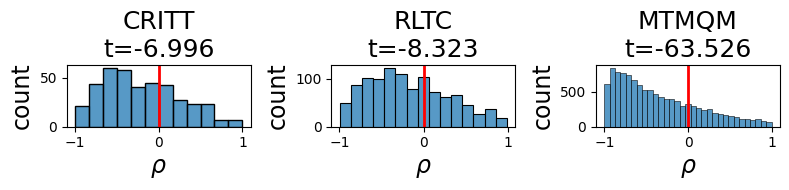

In [222]:
tradeoff_pair = ('p_x|y', 'p_y_mt')
ft0, ft1 = tradeoff_pair
val = f'{ft0}-{ft1}-corr-nonsig'

fig, axes = plt.subplots(1, 3, figsize=(8, 2))
for i, corp in enumerate([ 'critt', 'rltc', 'mtmqm']):
    tradeoff_df = corp_tradeoff_df[corp]
    perm_tradeoff_df = perm_corp_tradeoff_df[corp]
    hist_plot(axes[i], corp, tradeoff_df, perm_tradeoff_df, val)
                         
plt.tight_layout()
# plt.suptitle(f'Tradeoff between ' +r'$\mathrm{accuracy}_M$'+ ' and ' + r'$\mathrm{fluency}_M$', y=1.1, size=20)
plt.savefig('figures/tradeoff.pdf', bbox_inches='tight', dpi=1200, format='pdf')
plt.show()

$p$<.001
$p$<.001


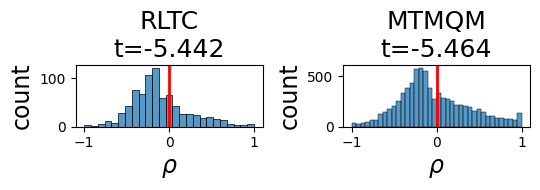

In [209]:
fig, axes = plt.subplots(1, 2, figsize=(5.5, 2))
for i, corp in enumerate(['rltc', 'mtmqm']):
    tradeoff_pair = corp_label_tradeoff_pairs[corp][0]
    ft0, ft1 = tradeoff_pair
    val = f'{ft0}-{ft1}-corr-nonsig'
    
    tradeoff_df = corp_tradeoff_df[corp]
    perm_tradeoff_df = perm_corp_tradeoff_df[corp]
    
    hist_plot(axes[i], corp, tradeoff_df, perm_tradeoff_df, val)
                         
plt.tight_layout()
# plt.suptitle(f'Tradeoff between accuracy and fluency ratings', y=1.1, x=0.55, size=20)
plt.savefig('figures/human-tradeoff.pdf', bbox_inches='tight', dpi=1200, format='pdf')
plt.show()

##### Simpson's paradox

In [259]:
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
def hue_regplot(data, x, y, hue, levels, markers, palette=None, **kwargs):
    regplots = []
    
    if palette is None:
        # default_colors = get_cmap('tab10')
        # palette = {k: default_colors(i) for i, k in enumerate(levels)}
        default_colors = dict(zip(levels, list(mcolors.TABLEAU_COLORS.keys())))
        palette = {k: default_colors[k] for k in levels}
        print(palette)
    
    for key, marker in zip(levels, markers):
        regplots.append(
            sns.regplot(
                x=x,
                y=y,
                data=data[data[hue] == key],
                color=palette[key],
                marker=marker,
                **kwargs
            )
        )
    
    return regplots, levels

{'newstest2020_ende_sciencedaily.com.75569_428': 'tab:blue', 'generalMT2022_ende_conversation_en_de_CLIENT-02_default_2021-02-07-1_doc0:English-German_95': 'tab:orange', 'generalMT2023_ende_mastodon_ashanti-development-working-with-farming-communities-in-ghana.110350775326024000:en-de_2': 'tab:green'}
PearsonRResult(statistic=0.4406003151799228, pvalue=0.021437124702921848)
['newstest2020_ende_sciencedaily.com.75569_428', 'generalMT2022_ende_conversation_en_de_CLIENT-02_default_2021-02-07-1_doc0:English-German_95', 'generalMT2023_ende_mastodon_ashanti-development-working-with-farming-communities-in-ghana.110350775326024000:en-de_2']
PearsonRResult(statistic=0.736448737154702, pvalue=1.1895006669944653e-05)
{'newstest2020_ende_sciencedaily.com.75569_428': 'tab:blue', 'generalMT2022_ende_conversation_en_de_CLIENT-02_default_2021-02-07-1_doc0:English-German_95': 'tab:orange', 'generalMT2023_ende_mastodon_ashanti-development-working-with-farming-communities-in-ghana.110350775326024000:en-d

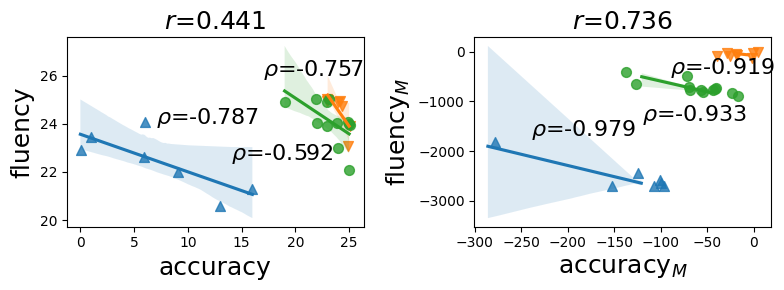

In [260]:
import matplotlib.ticker as ticker
def get_source_tradeoff(src_id, tradeoff_df, tradeoff_val='MQM_acc_score-MQM_flu_score-corr-nonsig'):
    return tradeoff_df[tradeoff_df['src_sent_id'] == src_id][tradeoff_val].values[0]

sentences = ['newstest2020_ende_sciencedaily.com.75569_428',
       'generalMT2022_ende_conversation_en_de_CLIENT-02_default_2021-02-07-1_doc0:English-German_95',
       'generalMT2023_ende_mastodon_ashanti-development-working-with-farming-communities-in-ghana.110350775326024000:en-de_2']

sdf = filtered_corp_df['mtmqm'][filtered_corp_df['mtmqm']['src_sent_id'].isin(sentences)]


fig, axes = plt.subplots(1, 2, figsize=(8, 3))
flacc_ax = axes[0]

_, labels = hue_regplot(sdf, x='MQM_acc_score', y='MQM_flu_score', hue='src_sent_id',  levels=sentences, ax=flacc_ax,  markers=['^', 'v', 'o']
                        ,scatter_kws={'s':50}, x_jitter=0.1, y_jitter=0.1)


r = pearsonr(sdf['MQM_acc_score'], sdf['MQM_flu_score'])
print(r)
flacc_ax.set_title(r'$r$=' + f'{r.statistic:.3f}', size=18)

print(labels)

flacc_ax.set_xlabel('accuracy', size=18)
flacc_ax.set_ylabel('fluency', size=18)


flacc_ax.annotate(r'$\rho$=' + f'{get_source_tradeoff(sentences[0], corp_tradeoff_df["mtmqm"], tradeoff_val="MQM_acc_score-MQM_flu_score-corr-nonsig"):.03f}', 
                 xy=(15, 20), xytext=( 7, 24), size=16)
flacc_ax.annotate(r'$\rho$=' + f'{get_source_tradeoff(sentences[2], corp_tradeoff_df["mtmqm"], tradeoff_val="MQM_acc_score-MQM_flu_score-corr-nonsig"):.03f}', 
                 xy=(15, 20), xytext=(14, 22.5), size=16)
flacc_ax.annotate(r'$\rho$=' + f'{get_source_tradeoff(sentences[1], corp_tradeoff_df["mtmqm"], tradeoff_val="MQM_acc_score-MQM_flu_score-corr-nonsig"):.03f}', 
                 xy=(15, 20), xytext=( 17, 26), size=16)

r = pearsonr(sdf['p_x|y'], sdf['p_y_mt'])
print(r)
prob_ax = axes[1]
_, labels = hue_regplot(sdf, x='p_x|y', y='p_y_mt', hue='src_sent_id', levels=sentences, markers=['^', 'v', 'o'], ax=prob_ax, scatter_kws={'s':50},
                       x_jitter=30, y_jitter=80)

prob_ax.set_title(r'$r$=' + f'{r.statistic:.3f}', size=18)
print(labels)
prob_ax.set_xlabel(r'$\mathrm{accuracy}_M$', size=18)
prob_ax.set_ylabel(r'$\mathrm{fluency}_M$', size=18)


prob_ax.annotate(r'$\rho$=' + f'{get_source_tradeoff(sentences[0], corp_tradeoff_df["mtmqm"], tradeoff_val="p_x|y-p_y_mt-corr-nonsig"):.03f}', 
                 xy=( -285.85, -1923.54), xytext=( -240, -1700), size=16)
prob_ax.annotate(r'$\rho$=' + f'{get_source_tradeoff(sentences[2], corp_tradeoff_df["mtmqm"], tradeoff_val="p_x|y-p_y_mt-corr-nonsig"):.03f}', 
                 xy=( -285.85, -1923.54), xytext=( -120, -1400), size=16)
prob_ax.annotate(r'$\rho$=' + f'{get_source_tradeoff(sentences[1], corp_tradeoff_df["mtmqm"], tradeoff_val="p_x|y-p_y_mt-corr-nonsig"):.03f}', 
                 xy=( -285.85, -1923.54), xytext=( -90, -450), size=16)

 

plt.tight_layout()
plt.savefig('figures/simpson-paradox.pdf', bbox_inches='tight', dpi=1200, format='pdf')
plt.show()

##### Manual analysis

In [261]:
def df2latex(df):
    for index, row in df.iterrows():
        values = list(row.values)
        trans = values[0].replace('_', '\_')
        vals = f'accuracy: {values[1]}, fluency: {values[2]}, ' + f'\\accuracym: {values[3]}, ' + f'\\fluencym: {values[4]}, ' + r'$\og p(y|x)$: ' + f'{values[5]}'
        # values[1] =  '\makecell[l]{' + values[1] + '}'  
        print(trans + '\\\\ \{' + vals + '\} \\\\\\midrule')
        


sdf = filtered_corp_df['mtmqm'][filtered_corp_df['mtmqm']['src_sent_id'].isin(sentences)]
sentence_df = sdf[sdf['src_sent_id'] ==  'generalMT2022_ende_conversation_en_de_CLIENT-02_default_2021-02-07-1_doc0:English-German_95'][[
    'source', 'system', 'target',  'MQM_acc_score', 'MQM_flu_score',  'p_x|y', 'p_y_mt', 'p_y|x', 'category', 'severity']].sort_values('MQM_acc_score')
# sentence_df
print(sentence_df.source.values[0])
print()
sentence_df[[ 'system', 'target',  'MQM_acc_score', 'MQM_flu_score',  'p_x|y', 'p_y_mt', 'p_y|x']]

df2latex(sentence_df[[ 'target',  'MQM_acc_score', 'MQM_flu_score',  'p_x|y', 'p_y_mt', 'p_y|x']])

I issued you a refund of the book.

Ich gab Ihnen eine Rückerstattung des Buches.\\ \{accuracy: 23.0, fluency: 25.0, \accuracym: -10.8125, \fluencym: -56.0, $\og p(y|x)$: -10.3125\} \\\midrule
Ich habe dir eine Rückerstattung des Buches ausgestellt.\\ \{accuracy: 23.0, fluency: 25.0, \accuracym: -5.84375, \fluencym: -62.5, $\og p(y|x)$: -12.4375\} \\\midrule
Ich habe dir das Buch zurückerstattet.\\ \{accuracy: 23.0, fluency: 25.0, \accuracym: -17.5, \fluencym: -44.25, $\og p(y|x)$: -7.625\} \\\midrule
Ich habe Ihnen das Buch erstattet.\\ \{accuracy: 24.0, fluency: 25.0, \accuracym: -15.1875, \fluencym: -43.25, $\og p(y|x)$: -9.0625\} \\\midrule
Ich habe Ihnen das Buch zurückerstattet.\\ \{accuracy: 24.2, fluency: 25.0, \accuracym: -17.25, \fluencym: -43.5, $\og p(y|x)$: -7.28125\} \\\midrule
Ich habe Ihnen eine Rückerstattung des Buches ausgestellt.\\ \{accuracy: 24.333333333333332, fluency: 24.666666666666668, \accuracym: -6.125, \fluencym: -64.0, $\og p(y|x)$: -12.125\} \\\midrule
Ic

##### Statistical properties

In [254]:
for i, ocorp in enumerate(['mtmqm', 'rltc', 'critt']):
    df = filtered_corp_df[ocorp]
    print(ocorp, pearsonr(df['p_x|y'], df['p_y_mt']))

mtmqm PearsonRResult(statistic=0.6754200612785926, pvalue=0.0)
rltc PearsonRResult(statistic=0.6846468212964137, pvalue=0.0)
critt PearsonRResult(statistic=0.6249251363261122, pvalue=0.0)


In [46]:
for i, ocorp in enumerate(['mtmqm', 'rltc']):
    df = filtered_corp_df[ocorp]
    ft0, ft1 = corp_label_tradeoff_pairs[ocorp][0]
    print(ocorp, ft0, ft1,  pearsonr(df[ft0], df[ft1]))

mtmqm MQM_acc_score MQM_flu_score PearsonRResult(statistic=0.39628719811956814, pvalue=0.0)
rltc accuracy fluency PearsonRResult(statistic=-0.08470508726068293, pvalue=1.93142036744542e-19)


In [174]:

estimated_tradeoff_pair = ('p_x|y', 'p_y_mt')
for i, ocorp in enumerate(['rltc', 'mtmqm']):

    hft0, hft1 = corp_label_tradeoff_pairs[ocorp][0]
    mft0, mft1 = estimated_tradeoff_pair
    
    hval = f'{hft0}-{hft1}-corr-nonsig'
    mval = f'{mft0}-{mft1}-corr-nonsig'
    
    for j, corp in enumerate([ocorp]):
        if corp in corp_tradeoff_df:
            tradeoff_df = corp_tradeoff_df[corp]
            df = tradeoff_df[[hval, mval]].dropna()
            print(corp, len(df), pearsonr(df[hval], df[mval]))


rltc 804 PearsonRResult(statistic=0.0051132992867993525, pvalue=0.884898447990851)
mtmqm 7872 PearsonRResult(statistic=0.02362412185872268, pvalue=0.036082800721277564)


### RQ1B: Fluency and accuracy

In [39]:
def correlation_comparison_mqm(data, x, ys):
    corr_dict = {'corpus': [], 'lpair': []}
    for y in ys:
        corr_dict[y] = []
        
    bar_plot_dict = {'corpus-lpair': [], 'corr': [], 'y':[], 'year': []}

    for i, (corpus, lpair_dfs) in enumerate(data.groupby('corpus')):
        for j, (lpair, df) in enumerate(lpair_dfs.groupby('lpair')):
            if lpair != 'enru':
                corr_dict['corpus'].append(corpus)
                corr_dict['lpair'].append(lpair)
                
                for y in ys:
                    sdf = df[[x, y]].dropna()
                    r = pearsonr(sdf[x].values, sdf[y].values)
                    corr_dict[y].append(tuple(r))
                    bar_plot_dict['corpus-lpair'].append(f'{corpus}\n{lpair}')
                    bar_plot_dict['y'].append(y)
                    bar_plot_dict['corr'].append(r.statistic)
                    if corpus!= 'ted':
                        bar_plot_dict['year'].append(int(corpus[-4:]))
                    else:
                        bar_plot_dict['year'].append(2021)
                        
    plot_df = pd.DataFrame.from_dict(bar_plot_dict, orient='index').transpose()
    plot_df = plot_df.sort_values(by='year')
    return pd.DataFrame.from_dict(corr_dict,orient='index').transpose(), plot_df

In [71]:
label_name = {'p_y|x': r'$\log p(y|x)$', 'p_x|y': r'$\log p(x|y)$', 'p_y_mt': r'$\log p(y)$'}


In [269]:
filtered_corp_df['rltc']['p_y|x_pct'] = filtered_corp_df['rltc']['p_y|x'].rank(pct=True, ascending=False)

preds = ['p_y|x', 'p_x|y', 'p_y_mt']
bar_dict = {'corr': [], 'human rating': [], 'predictor': []}
for pred in preds:
    for y in ['accuracy', 'fluency']:
        sdf = filtered_corp_df['rltc'][[f'{pred}_pct', f'{y}_pct']].dropna()
        r = pearsonr(sdf[f'{pred}_pct'].values, sdf[f'{y}_pct'].values)
        print(r)
        bar_dict['corr'].append(r[0])
        bar_dict['human rating'].append(y)
        bar_dict['predictor'].append(pred)

PearsonRResult(statistic=0.1942284867502753, pvalue=1.9692822195690785e-96)
PearsonRResult(statistic=0.16826970982839104, pvalue=1.6518213620358713e-72)
PearsonRResult(statistic=0.15791427385705809, pvalue=5.6798006006237004e-64)
PearsonRResult(statistic=0.06951544788002152, pvalue=1.4060049893336684e-13)
PearsonRResult(statistic=0.17218871698660304, pvalue=6.898224229985427e-76)
PearsonRResult(statistic=0.21831614831927912, pvalue=6.172706487362982e-122)


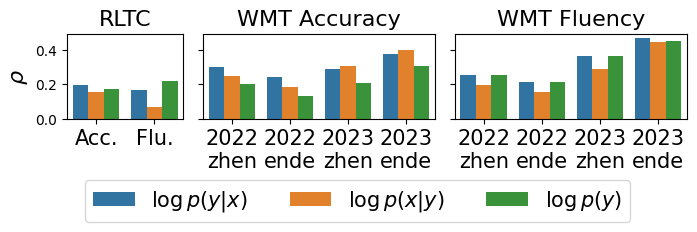

In [192]:
ys = ['p_y|x', 'p_x|y', 'p_y_mt']
ys = [f'{y}_pct'for y in ys]

filtered_corp_df['mtmqm']['p_y|x_pct']  = filtered_corp_df['mtmqm']['p_y|x'].rank(pct=True, ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(8, 1.1), sharey=True, gridspec_kw={'width_ratios': [1, 2, 2],  'wspace':0.1})

ax = axes[0]
ax = sns.barplot(pd.DataFrame(bar_dict), y='corr', x='human rating', hue='predictor', ax=ax)
ax.set_ylabel(r'$\rho$', size=16)
ax.set_title('RLTC', size=16)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=[label_name[l] for l in labels[0:]], fontsize=13, bbox_to_anchor=(1.01, 0.9))
ax.set(xlabel=None)
ax.set_xticklabels(['Acc.', 'Flu.'], size=15)
ax.get_legend().remove()


ax = axes[1]
mqm_acc_corr, mqm_acc_corr_bar = correlation_comparison_mqm(filtered_corp_df['mtmqm'], 'MQM_acc_score_pct', ys)
mqm_acc_corr_bar = mqm_acc_corr_bar[mqm_acc_corr_bar['year'] >= 2022]

# sns.set(font_size = 12)
sns.barplot(mqm_acc_corr_bar, x='corpus-lpair', y='corr', hue='y', ax=ax, hue_order=ys)
ax.set_title('WMT Accuracy', size=16)
ax.set(xlabel=None)
ax.set_ylabel(r'$\rho$', size=15)
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
ax.set_ylabel(None)
mqm_acc_corr_bar['year-lpair'] = mqm_acc_corr_bar['corpus-lpair'].apply(lambda x: x[-9:])
ax.set_xticks(range(len(mqm_acc_corr_bar['year-lpair'].unique())), mqm_acc_corr_bar['year-lpair'].unique() , size=15)


ax = axes[2]
mqm_flu_corr, mqm_flu_corr_bar = correlation_comparison_mqm(filtered_corp_df['mtmqm'], 'MQM_flu_score_pct', ys)
mqm_flu_corr_bar = mqm_flu_corr_bar[mqm_flu_corr_bar['year'] >= 2022]
# fig, ax = plt.subplots(1, 1, figsize=(4, 2))
# sns.set(font_size = 12)
sns.barplot(mqm_flu_corr_bar, x='corpus-lpair', y='corr', hue='y', ax=ax, hue_order=ys)

ax.set_title('WMT Fluency', size=16)
ax.set(xlabel=None)
# ax.set_ylabel(r'$\rho$', size=15)
ax.set_ylabel(None)
handles, labels = ax.get_legend_handles_labels()

mqm_flu_corr_bar['year-lpair'] = mqm_flu_corr_bar['corpus-lpair'].apply(lambda x: x[-9:])
ax.set_xticks(range(len(mqm_flu_corr_bar['year-lpair'].unique())), mqm_flu_corr_bar['year-lpair'].unique(), size=15)


ax.legend(handles=handles[0:], labels=[label_name[l] for l in labels[0:]], fontsize=15, bbox_to_anchor=(0.8, -0.6), ncol=3)

plt.tight_layout()
plt.savefig('figures/prob-acc-flu-bar.pdf', bbox_inches='tight', dpi=1200, format='pdf')

In [267]:
mqm_acc_corr

,corpus,lpair,p_y|x_pct,p_x|y_pct,p_y_mt_pct
0,generalMT2022,ende,"(0.24303801171109754, 4.6237644321629695e-168)","(0.18420075646453474, 3.829334913648166e-96)","(0.1297856922185822, 2.9895790559306614e-48)"
1,generalMT2022,zhen,"(0.30012287106104385, 0.0)","(0.2506143318213959, 6.23e-322)","(0.2029493986188862, 1.6813484108745047e-209)"
2,generalMT2023,ende,"(0.3752218950484103, 1.7450211015167708e-165)","(0.40251327206372045, 2.0086452795446445e-192)","(0.30884671090304616, 5.2860336277068305e-110)"
3,generalMT2023,zhen,"(0.28985348373837655, 4.90199841700735e-284)","(0.30894398110111865, 0.0)","(0.2082002367085775, 1.8301639900651934e-144)"
4,newstest2020,ende,"(0.361031205298309, 4.6719913797155614e-259)","(0.277350160051917, 2.3109408399799063e-149)","(0.23056787053078745, 1.4524680260420702e-102)"
5,newstest2020,zhen,"(0.5331432434698894, 0.0)","(0.4452425571893752, 0.0)","(0.3865117549742291, 0.0)"
6,newstest2021,ende,"(0.13283219688600595, 6.589511799621931e-23)","(0.12476300997414458, 2.2347892367103253e-20)","(0.0904704620406026, 2.1509431765647458e-11)"
7,newstest2021,zhen,"(0.38365406009629505, 2.079574597811689e-251)","(0.310763291695857, 4.032215142571372e-161)","(0.3014279794608466, 3.0436297290136203e-151)"
8,ted,ende,"(0.21090770291839953, 1.8431017209120752e-40)","(0.17512021106967884, 3.129680439003766e-28)","(0.13229322987253558, 1.0808839435090333e-16)"
9,ted,zhen,"(0.26800447339303646, 5.027716503319932e-72)","(0.23444098389979195, 4.546052138143207e-55)","(0.19201638594035664, 3.4750098827317313e-37)"


In [266]:
mqm_flu_corr

,corpus,lpair,p_y|x_pct,p_x|y_pct,p_y_mt_pct
0,generalMT2022,ende,"(0.21561897030000188, 7.463887905719925e-132)","(0.1574052696655302, 2.1490303878616784e-70)","(0.2153243082725139, 1.7226550575213798e-131)"
1,generalMT2022,zhen,"(0.2577814832059647, 0.0)","(0.19821813422549697, 9.496161401576363e-200)","(0.2568951396471583, 0.0)"
2,generalMT2023,ende,"(0.4721722893119433, 1.0634803228365671e-273)","(0.44723297841432513, 2.158446583600942e-242)","(0.4566245343600142, 7.069163354636743e-254)"
3,generalMT2023,zhen,"(0.3657951827605334, 0.0)","(0.2881458142826876, 1.4114897179689153e-280)","(0.36679243836577036, 0.0)"
4,newstest2020,ende,"(0.34335970063281424, 6.527403424099203e-233)","(0.22312438173706484, 5.256483260849174e-96)","(0.30361447009088116, 4.849287145433992e-180)"
5,newstest2020,zhen,"(0.39064892909932886, 0.0)","(0.2656670497312945, 3.320369373434009e-220)","(0.3774208411670855, 0.0)"
6,newstest2021,ende,"(0.15852015572474606, 4.832778999936682e-32)","(0.1473660750541135, 7.142393712313573e-28)","(0.12811398970368573, 2.0792410273074953e-21)"
7,newstest2021,zhen,"(0.20769129071048875, 4.757787485941848e-71)","(0.12696845878958057, 2.765837431903796e-27)","(0.18593371774574774, 4.615465426407163e-57)"
8,ted,ende,"(0.16346093067949719, 9.226519620635047e-25)","(0.09669399551005199, 1.4414195066595151e-09)","(0.1686732533960672, 2.7843949625989355e-26)"
9,ted,zhen,"(0.17959166291625087, 1.1428402381502937e-32)","(0.13358316267948814, 1.1337625576978373e-18)","(0.19078352889101263, 1.0080464162817195e-36)"
